# Modeling with NN 

In [65]:
## Import need packages 
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization,Dropout

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [76]:
# defining a funciton with 
def create_model(units=60, dropout=0, reg=None):
    model = Sequential()
    model.add(Dense(12, input_shape=(1000,), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(units, activation='relu', kernel_regularizer = reg))
    model.add(Dropout(dropout))
 
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [77]:
# df_reviews = pd.read_csv('../data/Las_Vegas_400_reviews.csv')
# df_reviews = pd.read_csv('../data/Las_Vegas_all_1000_reviews.csv')
df_reviews = pd.read_csv('../data/Las_Vegas_all_reviews.csv')
df_revs_combined = df_reviews.groupby(['business_id', 'name', 
                               'address', 'city' ,
                               'state', 'postal_code', 
                               'latitude' ,'longitude' , 
                               'stars', 'review_count', 
                               'is_open', 'attributes', 'categories']).agg({'text': ' '.join})
df_revs_combined = df_revs_combined.reset_index()
df_revs_combined['review_wc'] = df_revs_combined['text'].str.split().str.len()

X = df_revs_combined['text']
y = df_revs_combined['is_open']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=251)

In [78]:
# using TfidfVectorizer and vectorizing both test and train data 
tf_vect = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_trans = tf_vect.fit_transform(X_train)
X_test_trans = tf_vect.transform(X_test)
X_train_trans = X_train_trans.toarray()
X_test_trans = X_test_trans.toarray()

In [79]:
X_train_trans.shape, X_test_trans.shape

((1326, 1000), (442, 1000))

In [42]:
# creating Standard Scaler, model and pipe for grid search 
sscaler = StandardScaler(with_mean=False)
model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)
pipe = make_pipeline(sscaler,model)

In [44]:
# fit pipe 
pipe.fit(X_train_trans, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f794224afd0>)])

In [45]:
# setting params for grid search
params = {'kerasclassifier__units': [64, 128, 256, 512],
          'kerasclassifier__dropout':[0.2, 0.3, 0.4, 0.5],
          'kerasclassifier__reg':['l2', None],
         }
grid = GridSearchCV(pipe, param_grid=params)

In [46]:
# fitting Grid search 
grid.fit(X_train_trans, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kerasclassifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f794224afd0>)]),
             param_grid={'kerasclassifier__dropout': [0.2, 0.3, 0.4, 0.5],
                         'kerasclassifier__reg': ['l2', None],
                         'kerasclassifier__units': [64, 128, 256, 512]})

In [47]:
# get grid score for train
grid.score(X_train_trans, y_train)

0.9675716161727905

In [48]:
# get grid score for test
grid.score(X_test_trans, y_test)

0.7805429697036743

In [49]:
# get Best Param from grid search 
grid.best_params_

{'kerasclassifier__dropout': 0.5,
 'kerasclassifier__reg': None,
 'kerasclassifier__units': 128}

In [50]:
# null model for comparison 
df_revs_combined['is_open'].value_counts(normalize=True)

1    0.724548
0    0.275452
Name: is_open, dtype: float64

In [51]:
# Predict from test data
predics =  grid.predict(X_test_trans)

/home/babu/code/jupyterenvironment/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [53]:
# get True Negative, False positive, False Negative, and True Positive
tn, fp, fn,tp = confusion_matrix(y_test, predics).ravel()

In [54]:
print(tn, fp, fn,tp)

100 23 74 245


In [56]:
# Generate other metrics 
precision = tp / (tp+fp)
recall = tp / (tp+fn)
specificity = tn/(tn+fp)
balanced_accuracy = (specificity + recall)/2
ac = accuracy_score(y_test, predics)
fpr = fp / (fp+tn) # False Positive Rate 
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" Specificity: {recall}")
print(f" Balanced Accuracy: {balanced_accuracy}")
print(f" Accuracy Score: {ac}")
print(f" False Positive Rate : {fpr}")

 Precision: 0.914179104477612
 Recall: 0.768025078369906
 Specificity: 0.768025078369906
 Balanced Accuracy: 0.7905166042256033
 Accuracy Score: 0.7805429864253394
 False Positive Rate : 0.18699186991869918


# Running NN with best Params

#### dropout =  0.5
####  reg = 'l2'
#### units =  128

In [57]:
# Scale both test and train data 
sscaler = StandardScaler(with_mean=False)
X_train_scaled = sscaler.fit_transform(X_train_trans)
X_test_scaled = sscaler.transform(X_test_trans)

In [59]:
# create and compile Neural Network 
model = Sequential()
model.add(Dense(12, input_shape=(1000,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer = 'l2'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# get Model Summary 
model.summary()

Model: "sequential_329"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_987 (Dense)            (None, 12)                12012     
_________________________________________________________________
batch_normalization_329 (Bat (None, 12)                48        
_________________________________________________________________
dense_988 (Dense)            (None, 128)               1664      
_________________________________________________________________
dropout_329 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_989 (Dense)            (None, 1)                 129       
Total params: 13,853
Trainable params: 13,829
Non-trainable params: 24
_________________________________________________________________


In [61]:
# fit the model and get the accuracy and val_accuracy score 
history = model.fit(X_train_trans, y_train, validation_data=(X_test_trans, y_test), epochs = 10)

Epoch 1/10
42/42 [==============================] - 1s 4ms/step - loss: 0.8445 - accuracy: 0.6719 - val_loss: 0.7952 - val_accuracy: 0.7217
Epoch 2/10
42/42 [==============================] - 0s 2ms/step - loss: 0.7001 - accuracy: 0.7201 - val_loss: 0.7206 - val_accuracy: 0.7217
Epoch 3/10
42/42 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy: 0.7768 - val_loss: 0.6749 - val_accuracy: 0.7217
Epoch 4/10
42/42 [==============================] - 0s 2ms/step - loss: 0.5067 - accuracy: 0.8327 - val_loss: 0.6299 - val_accuracy: 0.7217
Epoch 5/10
42/42 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.8737 - val_loss: 0.5981 - val_accuracy: 0.7217
Epoch 6/10
42/42 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.8900 - val_loss: 0.5835 - val_accuracy: 0.7217
Epoch 7/10
42/42 [==============================] - 0s 2ms/step - loss: 0.3474 - accuracy: 0.8869 - val_loss: 0.5543 - val_accuracy: 0.7262
Epoch 8/10
42/42 [==

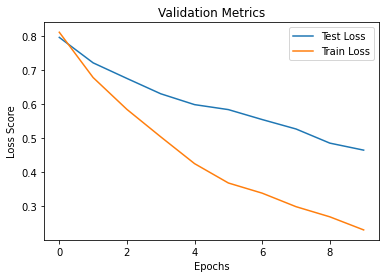

In [62]:
# plot test and train loss
plt.plot(history.history['val_loss'], label='Test Loss')
plt.plot(history.history['loss'], label="Train Loss")
plt.legend()
plt.title('Validation Metrics')
plt.xlabel("Epochs")
plt.ylabel("Loss Score");

In [70]:
# predict Y
y_pred = model.predict_classes(X_test_trans)

/home/babu/code/jupyterenvironment/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [71]:
# generate balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.7091775619950558

In [72]:
# get True Negative, False positive, False Negative, and True Positive
tn, fp, fn,tp = confusion_matrix(y_test, y_pred).ravel()

In [73]:
# Generate other metrics 
precision = tp / (tp+fp)
recall = tp / (tp+fn)
specificity = tn/(tn+fp)
balanced_accuracy = (specificity + recall)/2
ac = accuracy_score(y_test, predics)
fpr = fp / (fp+tn) # False Positive Rate 
print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" Specificity: {recall}")
print(f" Balanced Accuracy: {balanced_accuracy}")
print(f" Accuracy Score: {ac}")
print(f" False Positive Rate : {fpr}")

 Precision: 0.8181818181818182
 Recall: 0.987460815047022
 Specificity: 0.987460815047022
 Balanced Accuracy: 0.7091775619950558
 Accuracy Score: 0.7805429864253394
 False Positive Rate : 0.5691056910569106
